In [1]:
import sys
from pathlib import Path

module_path = str(Path().resolve().parent / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from curvature.tvg import *
from curvature.curvature_utils import *
from soap_parser.matrix import *
from soap_parser.tvg import draw_reeb_graph

import soap_parser.report_parser as rp
import networkx as nx

### Scenario A : Data Mule

In [2]:
scenario_a = "Data Mule"

edges_a = [(1, 2), (1, 3), (2, 4), (2, 5), (3, 6), (3, 7), (8, 9), (8, 10),
(9, 11), (9, 12), (10, 13), (10, 14), (15, 16), (15, 17), (16, 18), (16, 19),
(17, 20), (17, 21), (22, 23), (22, 24), (23, 25), (23, 26), (24, 27), (24, 28)]
edges_b = edges_a + [(0, 1), (0, 8)]
edges_c = edges_a + [(0, 15), (0, 22)]

a_list = 2 * [edges_a] + 2 * [edges_b] + 2 * [edges_a] + 2 * [edges_c]

matrix_a = IntervalMatrix(29, 29, labels = [str(k) for k in range(29)])
start = 0
for e in 10 * a_list:
    for i, j in e:
        matrix_a[i, j] |= P.closed(start, start + 1)
    start += 1
network_a = TemporalNetwork(matrix_a)
# print(f"A : critical times = {network_a.get_critical_times()}")

# rg_a = network_a.get_reeb_graph()
# draw_reeb_graph(rg_a)

# print(f"{[network_a.get_node_label(k) for k in network_a.graph.nodes()]}")
print(f"Network A has {len(network_a.graph.nodes())} nodes.")

Network A has 29 nodes.


### Scenario B : Starlink

In [3]:
scenario_b = "Starlink [20 Satellites]"

filepath = "./scenario_b.csv"
nodes, edges = rp.contact_analysis_report_parser(filepath)
nodes, edges = rp.filter_contact_plan(nodes, edges, substring_exclusion_list=["Mars", "Moon"])

matrix_b = rp.contact_plan_to_matrix(nodes, edges)
matrix_b = matrix_b.get_submatrix(list(range(20)), list(range(20)))
network_b = TemporalNetwork(matrix_b)

# rg_b = network_b.get_reeb_graph()
# draw_reeb_graph(rg_b)

# print(f"{[network_b.get_node_label(k) for k in network_b.graph.nodes()]}")
print(f"Network B has {len(network_b.graph.nodes())} nodes.")

Network B has 20 nodes.


### Scenario C : LunaNet

In [4]:
scenario_c = "LunaNet"

filepath = "./scenario_c.csv"
nodes, edges = rp.contact_analysis_report_parser(filepath)
nodes, edges = rp.filter_contact_plan(nodes, edges, substring_exclusion_list=["Mars", "Moon"])

matrix_c = rp.contact_plan_to_matrix(nodes, edges)
network_c = TemporalNetwork(matrix_c)
# print(network_c)

# rg_c = network_c.get_reeb_graph()
# draw_reeb_graph(rg_c)

# print(f"{[network_c.get_node_label(k) for k in network_c.graph.nodes()]}")
print(f"Network C has {len(network_c.graph.nodes())} nodes.")

Network C has 15 nodes.


### True Reeb Graphs

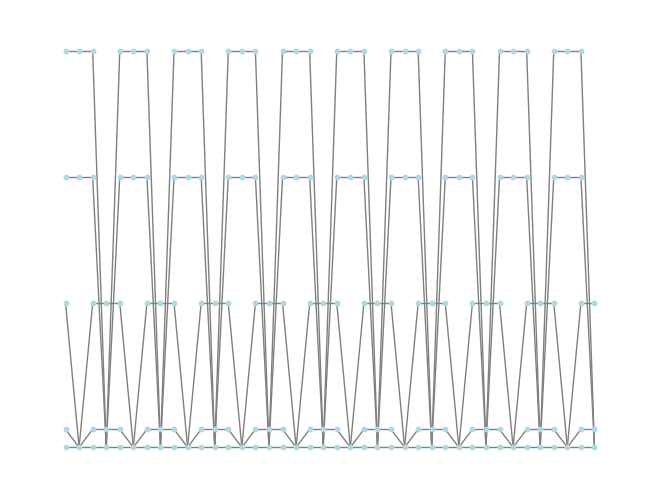

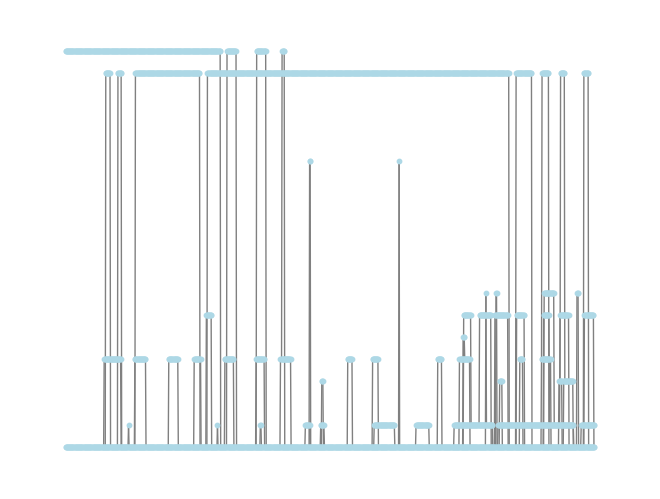

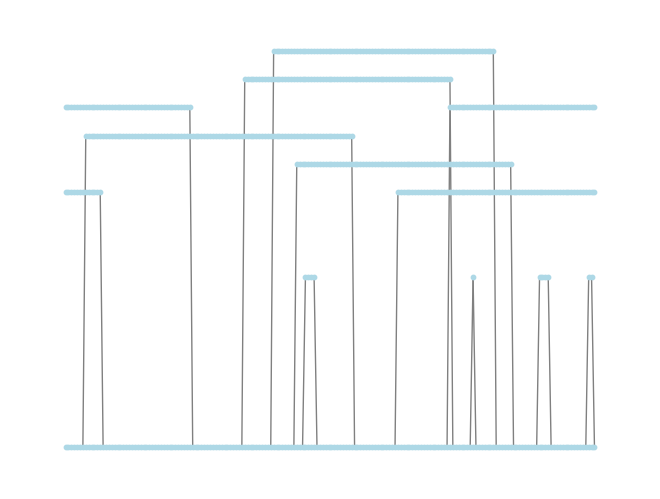

In [5]:
rg_a = network_a.get_reeb_graph()
draw_reeb_graph(rg_a)

rg_b = network_b.get_reeb_graph()
draw_reeb_graph(rg_b)

rg_c = network_c.get_reeb_graph()
draw_reeb_graph(rg_c)

### Evenly Sampled Reeb Graphs

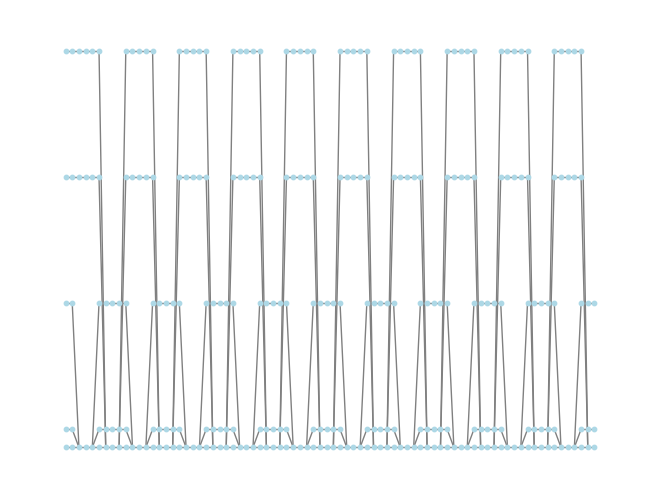

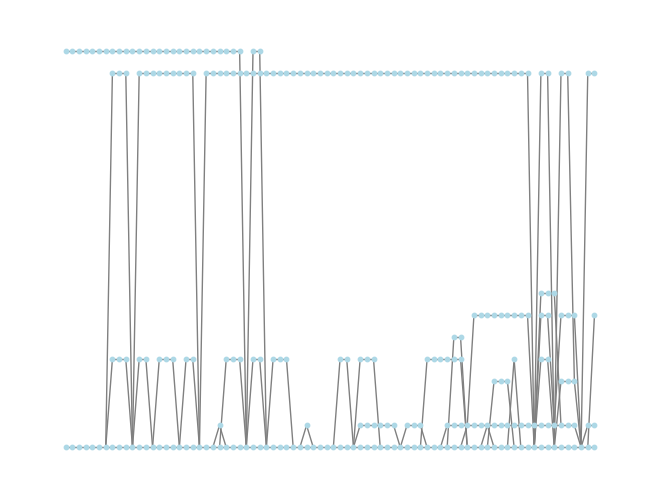

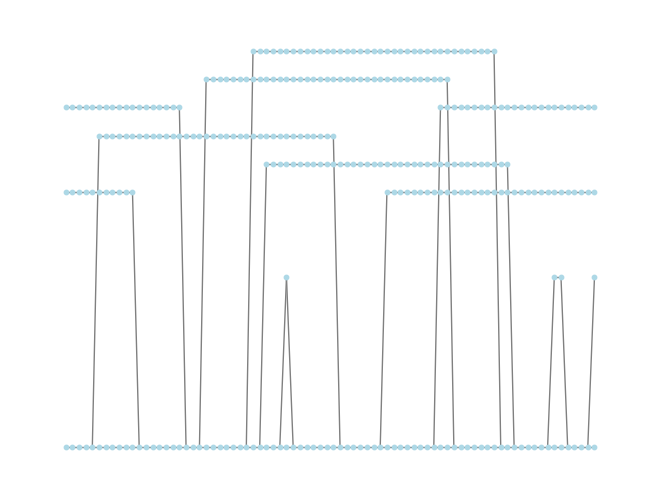

In [6]:
# scenario a : r = 1
rg_a = network_a.get_reeb_graph(np.arange(0, 80, 1).tolist())
draw_reeb_graph(rg_a)

# scenario's b and c : r = 1080
start_time, end_time, r = 0, 86400, 1080
sample_times = np.arange(start_time, end_time, r).tolist()

rg_b = network_b.get_reeb_graph(sample_times = sample_times)
draw_reeb_graph(rg_b)

rg_c = network_c.get_reeb_graph(sample_times = sample_times)
draw_reeb_graph(rg_c)

### Random Clusters

### Summary Graphs

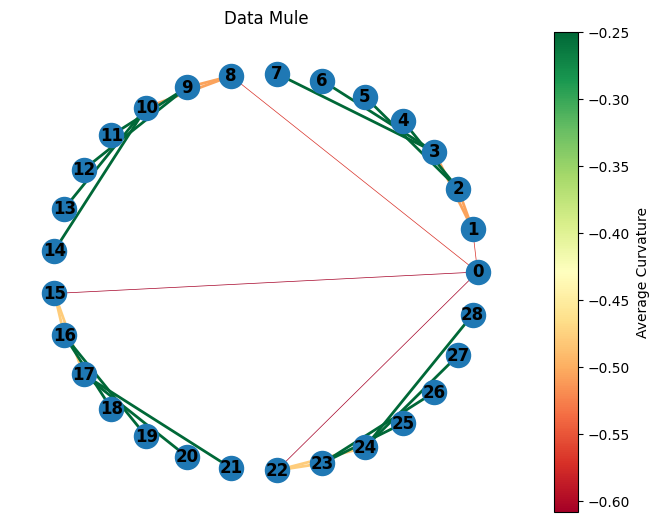

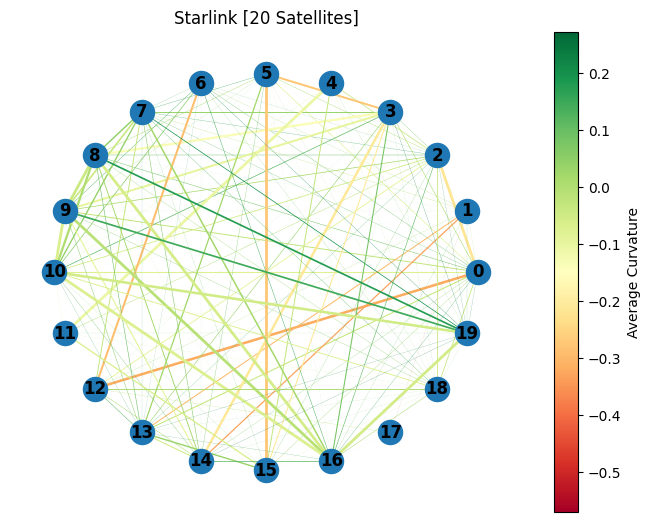

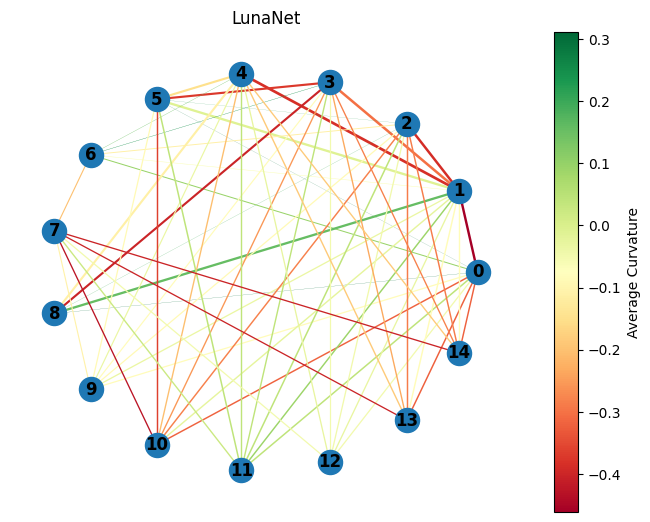

In [7]:
# network_a.get_summary_graph()
K = 1
r = 1080

draw_summary_graph(network_a, title = scenario_a)
draw_summary_graph(network_b, title = scenario_b, K = K, r = r)
draw_summary_graph(network_c, title = scenario_c, K = K, r = r)

### Bottleneck Analysis